In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [2]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [3]:
## Mac
path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [4]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [5]:

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_cont2"] = estreams_attributes["perm_high_cont"]
estreams_attributes["perm_medium_cont2"] = estreams_attributes["perm_medium_cont"] + estreams_attributes["perm_low_cont"]
estreams_attributes["perm_low_cont2"] = estreams_attributes["perm_verylow_cont"]


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [6]:
# First we define the outlet of the Moselle to be used
outlets = ["FR003986"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["FR003986"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]
estreams_attributes_clipped_filters

100%|██████████| 1/1 [00:00<00:00, 1698.10it/s]


,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR003936,L005063001,La Vienne Ã Eymoutiers,FR,FR_EAUFRANCE,La Vienne à Eymoutiers,1.743025,45.740291,1.743025,45.740291,400,...,2.448,0.628,0.088,2.0,0.0,12.0,88.0,0.000,0.000,100.000
FR003938,L023151001,Le Taurion Ã Pontarion,FR,FR_EAUFRANCE,Le Taurion à Pontarion,1.846800,45.996519,1.846800,45.996519,440,...,1.904,0.000,0.000,6.0,0.0,9.0,91.0,0.000,0.000,100.000
FR003939,L061402001,L'Aurence Ã Isle,FR,FR_EAUFRANCE,L'Aurence à Isle,1.189908,45.811068,1.189908,45.811068,230,...,0.844,0.583,0.792,2.0,0.0,92.0,8.0,0.000,0.323,99.677
FR003943,L094061001,La Vienne Ã Confolens,FR,FR_EAUFRANCE,La Vienne à Confolens,0.670063,46.013297,0.670063,46.013297,131,...,1.214,7.854,13.315,18.0,1.0,50.0,49.0,0.155,28.696,71.149
FR003949,L232161001,Le Clain Ã Vivonne [Danlot],FR,FR_EAUFRANCE,Le Clain à Vivonne [Danlot],0.285917,46.440096,0.285917,46.440096,80,...,0.775,117.758,169.495,10.0,27.0,69.0,4.0,9.405,82.333,8.262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FR001245,L532301001,L5323010,FR,FR_EAUFRANCE,La Brame à Oradour-Saint-Genest,0.998967,46.251704,0.998967,46.251704,161,...,0.940,0.082,0.284,2.0,0.0,38.0,62.0,0.000,3.759,96.241
FR001246,L540181001,L5401810,FR,FR_EAUFRANCE,La Gartempe à Lathus-Saint-Rémy [Pont de Massu...,0.933009,46.283917,0.933009,46.283917,121,...,1.072,2.274,3.454,7.0,0.0,27.0,73.0,0.122,14.271,85.607
FR001247,L573301001,L5733020,FR,FR_EAUFRANCE,Le Salleron à Journet [Tervannes],0.988622,46.489889,0.988622,46.489889,135,...,0.776,0.553,1.660,2.0,12.0,48.0,40.0,35.394,18.669,45.937


In [7]:
estreams_attributes_clipped_filters.corr(method="spearman")["baseflow_index"][-10:]

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_59923/3158332290.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  estreams_attributes_clipped_filters.corr(method="spearman")["baseflow_index"][-10:]


sno_cov_mean           0.218143
irri_1990              0.047526
irri_2005              0.034371
stations_num_p_mean    0.129892
perm_high_glob2       -0.030428
perm_medium_glob2     -0.123119
perm_low_glob2         0.062132
perm_high_cont2       -0.137919
perm_medium_cont2      0.003847
perm_low_cont2         0.003652
Name: baseflow_index, dtype: float64

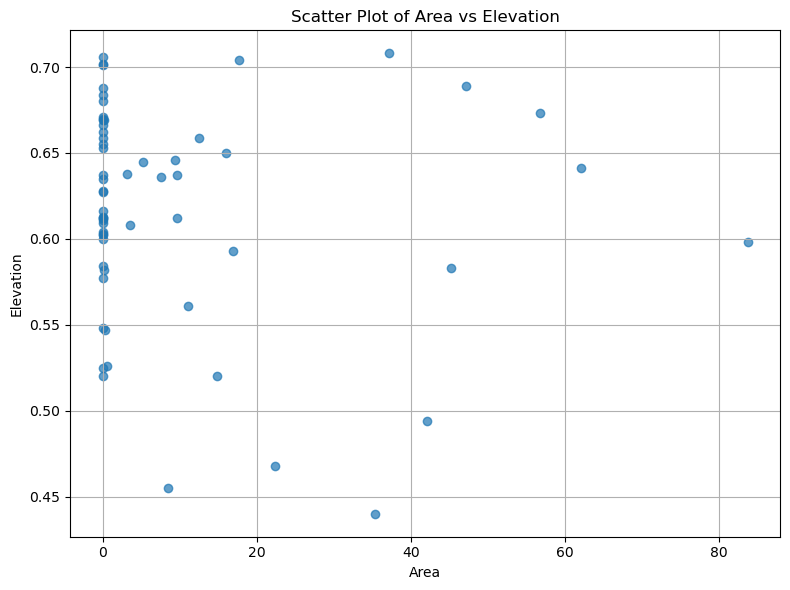

In [9]:
import matplotlib.pyplot as plt

# Example: Plot 'area' vs 'elevation'
plt.figure(figsize=(8, 6))
plt.scatter(estreams_attributes_clipped_filters["perm_high_cont2"], estreams_attributes_clipped_filters["baseflow_index"], alpha=0.7)
plt.xlabel("Area")
plt.ylabel("Elevation")
plt.title("Scatter Plot of Area vs Elevation")
plt.grid(True)
plt.tight_layout()
plt.show()


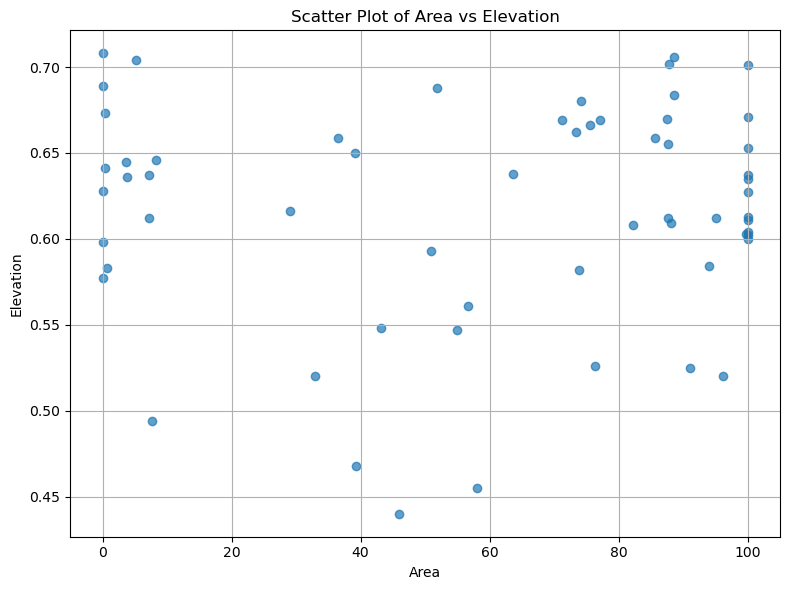

In [11]:
import matplotlib.pyplot as plt

# Example: Plot 'area' vs 'elevation'
plt.figure(figsize=(8, 6))
plt.scatter(estreams_attributes_clipped_filters["perm_low_cont2"], estreams_attributes_clipped_filters["baseflow_index"], alpha=0.7)
plt.xlabel("Area")
plt.ylabel("Elevation")
plt.title("Scatter Plot of Area vs Elevation")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
len(estreams_attributes_clipped_filters)

61

In [11]:
estreams_attributes_clipped_filters

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR003936,L005063001,La Vienne Ã Eymoutiers,FR,FR_EAUFRANCE,La Vienne à Eymoutiers,1.743025,45.740291,1.743025,45.740291,400,...,2.448,0.628,0.088,2.0,0.0,12.0,88.0,0.000,0.000,100.000
FR003938,L023151001,Le Taurion Ã Pontarion,FR,FR_EAUFRANCE,Le Taurion à Pontarion,1.846800,45.996519,1.846800,45.996519,440,...,1.904,0.000,0.000,6.0,0.0,9.0,91.0,0.000,0.000,100.000
FR003939,L061402001,L'Aurence Ã Isle,FR,FR_EAUFRANCE,L'Aurence à Isle,1.189908,45.811068,1.189908,45.811068,230,...,0.844,0.583,0.792,2.0,0.0,92.0,8.0,0.000,0.323,99.677
FR003943,L094061001,La Vienne Ã Confolens,FR,FR_EAUFRANCE,La Vienne à Confolens,0.670063,46.013297,0.670063,46.013297,131,...,1.214,7.854,13.315,18.0,1.0,50.0,49.0,0.155,28.696,71.149
FR003949,L232161001,Le Clain Ã Vivonne [Danlot],FR,FR_EAUFRANCE,Le Clain à Vivonne [Danlot],0.285917,46.440096,0.285917,46.440096,80,...,0.775,117.758,169.495,10.0,27.0,69.0,4.0,9.405,82.333,8.262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FR001245,L532301001,L5323010,FR,FR_EAUFRANCE,La Brame à Oradour-Saint-Genest,0.998967,46.251704,0.998967,46.251704,161,...,0.940,0.082,0.284,2.0,0.0,38.0,62.0,0.000,3.759,96.241
FR001246,L540181001,L5401810,FR,FR_EAUFRANCE,La Gartempe à Lathus-Saint-Rémy [Pont de Massu...,0.933009,46.283917,0.933009,46.283917,121,...,1.072,2.274,3.454,7.0,0.0,27.0,73.0,0.122,14.271,85.607
FR001247,L573301001,L5733020,FR,FR_EAUFRANCE,Le Salleron à Journet [Tervannes],0.988622,46.489889,0.988622,46.489889,135,...,0.776,0.553,1.660,2.0,12.0,48.0,40.0,35.394,18.669,45.937


In [8]:
basins_problems2 = pd.read_csv(r"../data/basins_problems_filter_2.csv")
basins_problems2

,basin
0,AT000080
1,AT000120
2,AT000159
3,AT000372
4,AT000373
...,...
369,SE000083
370,SE000103
371,SE000118
372,SI000029


In [9]:
Outliers = ["DEBB0050", 
"DK000087",
"ES000172",
"ES000478",
"ES001114",
"FI000202",
"FI000506",
"FR001271",
"FR001475",
"ITIS0107",
"NL000012",
"PT000211",
"PT000218",
"PT000263",
"DEHE0953",
"DEHE0970",
"DEHE0989",
"DEHE1008",
"DEHE1013",
"DEHE1014",
"DK000094"]

In [10]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters[~estreams_attributes_clipped_filters.index.isin(basins_problems2.basin)]
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters2.drop(["FR001217", "FR001219", "FR003943", "FR001180"])

len(estreams_attributes_clipped_filters2)

55

In [18]:
# Create a folder to save the plots
output_dir = r"..\results\plots\vienne"
os.makedirs(output_dir, exist_ok=True)

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    csv_file = fr"C:\Users\nascimth\Documents\data\EStreams\data\estreams_timeseries_{basin_id}.csv"
    
    df = pd.read_csv(csv_file)
    
    column_name = basin_id
    
    # Ensure the first column is treated as the Date index
    df.set_index(df.columns[0], inplace=True)
    df = df.loc["1988-10-01":"2015-09-30"]

    # Plotting
    plt.figure(figsize=(10, 4))
    df['q_mean'].plot(linewidth=0.5)
    plt.title(f"Basin: {basin_id}")
    plt.xlabel("Date")
    plt.ylabel("q_mean")
    #plt.xlim("1988","2015")

    #plt.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f"{basin_id}.png")
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid overlap in next iteration

100%|██████████| 61/61 [00:10<00:00,  5.87it/s]


<Axes: >

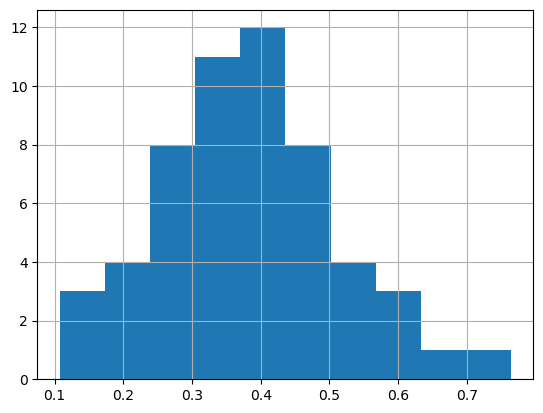

In [21]:
estreams_attributes_clipped_filters2.q_runoff_ratio.hist()

In [23]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3].q_runoff_ratio

basin_id
FR003952    0.289
FR003961    0.287
FR003972    0.291
FR003976    0.292
FR001207    0.230
FR001210    0.255
FR001214    0.239
FR001215    0.108
FR001216    0.251
FR001217    0.288
FR001218    0.250
FR001219    0.262
FR001223    0.226
FR001226    0.140
FR001247    0.249
FR001253    0.222
FR001257    0.138
Name: q_runoff_ratio, dtype: float64

In [24]:
estreams_attributes_clipped_filters2

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR003936,L005063001,La Vienne Ã Eymoutiers,FR,FR_EAUFRANCE,La Vienne à Eymoutiers,1.743025,45.740291,1.743025,45.740291,400,...,2.448,0.628,0.088,2.0,0.0,12.0,88.0,0.000,0.000,100.000
FR003938,L023151001,Le Taurion Ã Pontarion,FR,FR_EAUFRANCE,Le Taurion à Pontarion,1.846800,45.996519,1.846800,45.996519,440,...,1.904,0.000,0.000,6.0,0.0,9.0,91.0,0.000,0.000,100.000
FR003939,L061402001,L'Aurence Ã Isle,FR,FR_EAUFRANCE,L'Aurence à Isle,1.189908,45.811068,1.189908,45.811068,230,...,0.844,0.583,0.792,2.0,0.0,92.0,8.0,0.000,0.323,99.677
FR003949,L232161001,Le Clain Ã Vivonne [Danlot],FR,FR_EAUFRANCE,Le Clain à Vivonne [Danlot],0.285917,46.440096,0.285917,46.440096,80,...,0.775,117.758,169.495,10.0,27.0,69.0,4.0,9.405,82.333,8.262
FR003954,L320062001,La Vienne Ã Ingrandes,FR,FR_EAUFRANCE,La Vienne à Ingrandes,0.563578,46.877071,0.563578,46.877071,44,...,0.946,286.916,433.841,33.0,16.0,57.0,27.0,12.548,50.894,36.559
FR003955,L401071001,La Creuse Ã Felletin,FR,FR_EAUFRANCE,La Creuse à Felletin,2.167218,45.888371,2.167218,45.888371,510,...,2.943,0.000,0.000,4.0,0.0,34.0,66.0,0.000,0.000,100.000
FR003956,L420000301,La Creuse Ã Ahun [EDF - Busseau],FR,FR_EAUFRANCE,La Creuse à Ahun [EDF - Busseau],2.026490,46.124842,2.026490,46.124842,337,...,2.099,0.000,0.000,7.0,4.0,24.0,72.0,0.000,0.000,100.000
FR003957,L421071001,La Creuse Ã GlÃ©nic,FR,FR_EAUFRANCE,La Creuse à Glénic,1.918907,46.223859,1.918907,46.223859,310,...,1.868,0.000,0.000,7.0,3.0,18.0,79.0,0.000,0.000,100.000
FR003959,L440000101,La Petite Creuse Ã Genouillac [EDF],FR,FR_EAUFRANCE,La Petite Creuse à Genouillac [EDF],1.993689,46.357709,1.993689,46.357709,272,...,1.349,0.890,0.445,6.0,0.0,46.0,54.0,0.548,23.194,76.259


In [25]:
import pandas as pd
import os
import tqdm

data_folder = r"C:\Users\nascimth\Documents\data\EStreams\data"
gantt_segments = []

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters2.index):
    file_path = os.path.join(data_folder, f"estreams_timeseries_{basin_id}.csv")

    # Load CSV with datetime index
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = data.loc["1988-10-01":"2015-09-30"]

    # Get availability mask
    valid = data["q_mean"].notna()

    # Identify change points in availability (True to False or vice-versa)
    change_points = valid.ne(valid.shift()).cumsum()

    # Group by continuous segments
    for grp, seg in data[valid].groupby(change_points):
        start = seg.index.min()
        end = seg.index.max()
        gantt_segments.append((basin_id, start, end))


100%|██████████| 55/55 [00:02<00:00, 21.30it/s]


In [26]:
gantt_df = pd.DataFrame(gantt_segments, columns=["basin", "start", "end"])
gantt_df = gantt_df.sort_values(["basin", "start"]).reset_index(drop=True)

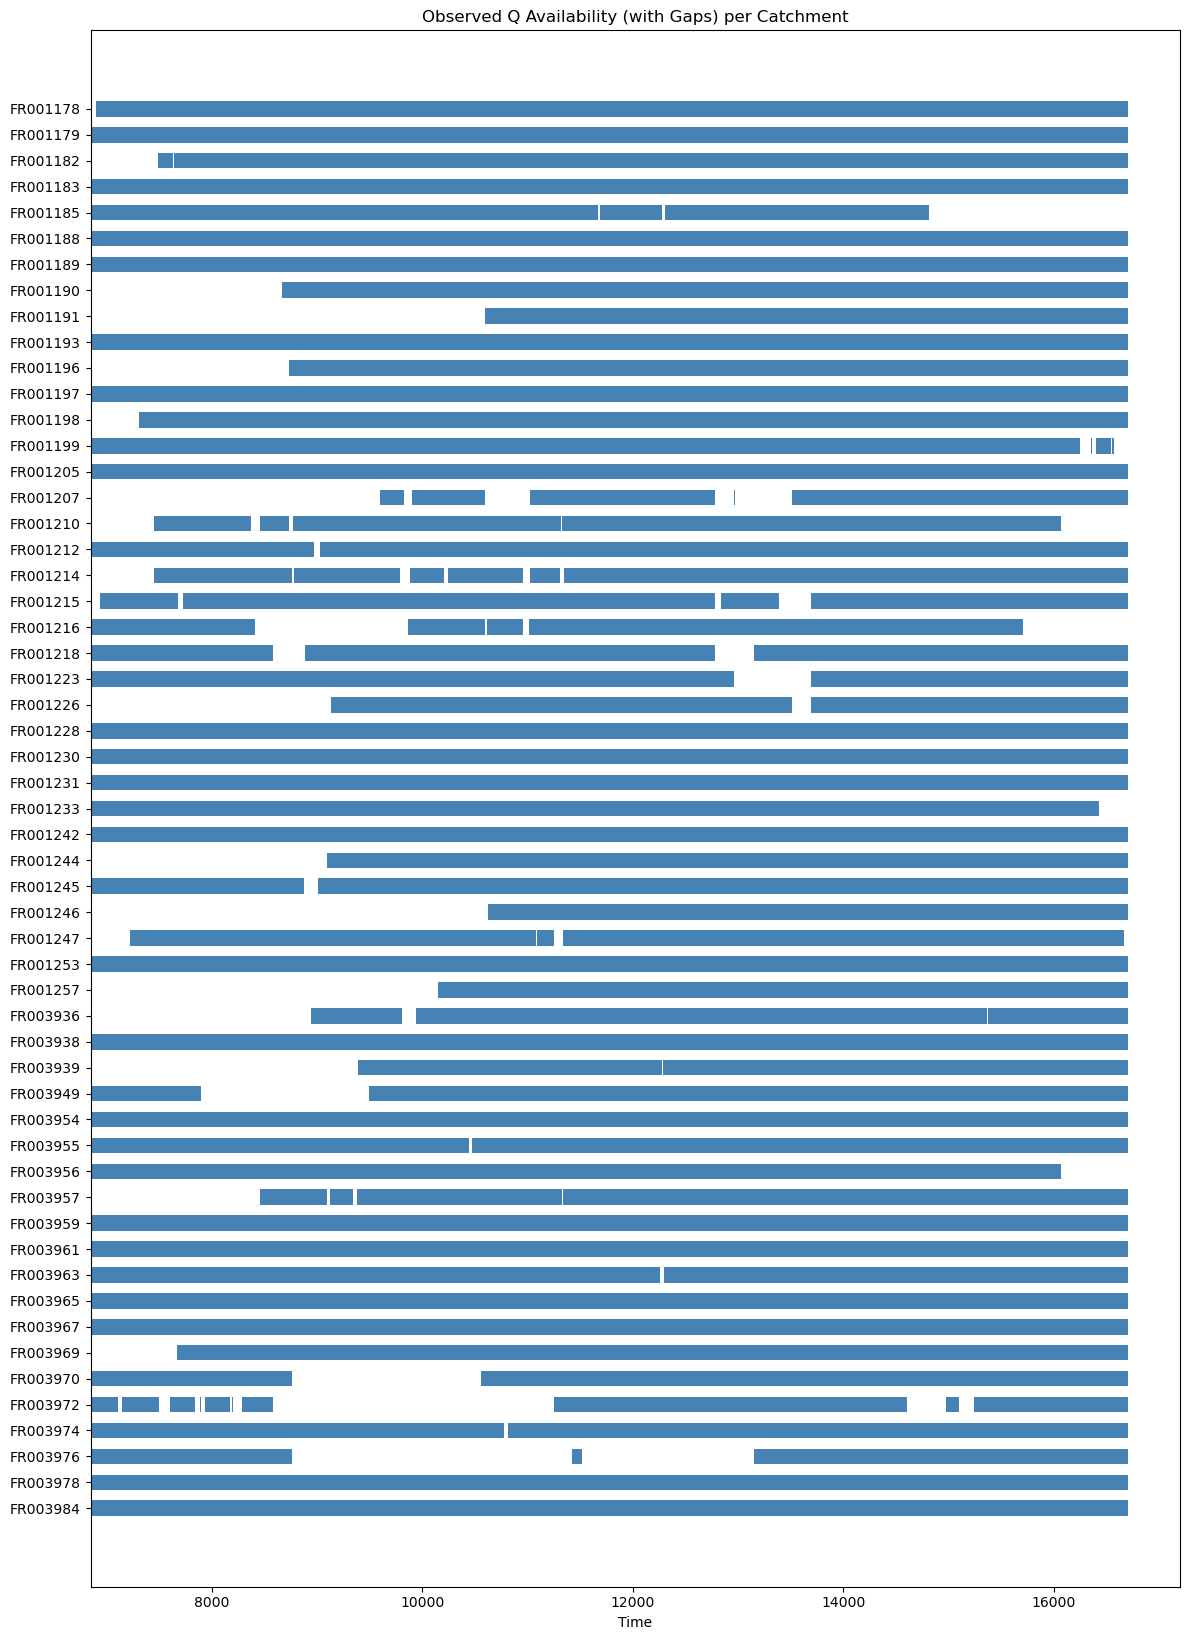

In [27]:
import matplotlib.pyplot as plt

# Assign a numeric index for plotting on y-axis
basin_to_y = {basin: i for i, basin in enumerate(gantt_df["basin"].unique())}
gantt_df["y"] = gantt_df["basin"].map(basin_to_y)

fig, ax = plt.subplots(figsize=(12, len(basin_to_y) * 0.3))

for _, row in gantt_df.iterrows():
    width = (row["end"] - row["start"]).days
    ax.barh(y=row["y"], left=row["start"], width=width, height=0.6, color="steelblue")

ax.set_yticks(list(basin_to_y.values()))
ax.set_yticklabels(list(basin_to_y.keys()))
ax.invert_yaxis()
ax.set_xlabel("Time")
ax.set_title("Observed Q Availability (with Gaps) per Catchment")
plt.tight_layout()
plt.show()


In [28]:
estreams_attributes_clipped_filters2[estreams_attributes_clipped_filters2.q_runoff_ratio<0.3].q_runoff_ratio

basin_id
FR003961    0.287
FR003972    0.291
FR003976    0.292
FR001207    0.230
FR001210    0.255
FR001214    0.239
FR001215    0.108
FR001216    0.251
FR001218    0.250
FR001223    0.226
FR001226    0.140
FR001247    0.249
FR001253    0.222
FR001257    0.138
Name: q_runoff_ratio, dtype: float64

In [11]:
estreams_attributes_clipped_filters_to_be_sorted = estreams_attributes_clipped_filters2.copy()

# At this part we sort the values in order according to the area, and select the second as done in the Moselle paper originally. 
# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_sorted = estreams_attributes_clipped_filters_to_be_sorted.sort_values(by='area_estreams')

estreams_attributes_clipped_sorted.loc[:, ["area_estreams"]]

,area_estreams
basin_id,
FR001178,59.725
FR001179,72.239
FR001185,79.473
FR003939,86.169
FR003965,129.370
FR001215,130.746
FR001188,131.777
FR001247,154.691
FR003967,174.712


In [30]:
import geopandas as gpd
moselle=gpd.read_file(r"..\data\shps\moselle_delienation.shp")
garonne=gpd.read_file(r"..\data\shps\garonne.shp")
five_cats=gpd.read_file(r"..\data\shps\five_cats.shp")

rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

### Current approach

In [12]:
import numpy as np
import pandas as pd

# Parameters
n_groups = 4

# Base dataframe
df_sorted = estreams_attributes_clipped_sorted.copy().reset_index(drop=True)
df_sorted["basin_id"] = estreams_attributes_clipped_sorted.index

total_gauges = len(df_sorted)

# Step 1: Sort by area for stratification
df_sorted = df_sorted.sort_values(by="area_estreams").reset_index(drop=True)

# Step 2: Determine gauges per group
gauges_per_group = total_gauges // n_groups
extra_gauges = total_gauges % n_groups  # Remainder

# Step 3: Create strata for balanced sampling
strata = np.array_split(df_sorted, total_gauges)

# Step 4: Round-robin assignment with randomness
np.random.seed(42)
grouped_gauges = {f'Group_{i+1}': [] for i in range(n_groups)}
group_cycle = list(grouped_gauges.keys()) * ((len(strata) // n_groups) + 2)
group_idx = 0

for stratum in strata:
    selected = stratum.sample(n=1, random_state=np.random.randint(10000)).iloc[0]
    group = group_cycle[group_idx]
    grouped_gauges[group].append(selected)
    group_idx += 1

# Step 5: Convert to DataFrames
groups_df = {k: pd.DataFrame(v).reset_index(drop=True) for k, v in grouped_gauges.items()}
all_combined = pd.concat(groups_df.values())

# Final checks
print(f"\n✅ Total gauges assigned: {len(all_combined)} (should be {len(df_sorted)})")
print(f"✅ Unique basin_ids: {all_combined['basin_id'].nunique()} (should be {len(df_sorted)})")
print(f"✅ Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# Summary per group
for k, g in groups_df.items():
    print(f"{k}: {len(g)} gauges | Mean area: {g['area_estreams'].mean():.1f}")



✅ Total gauges assigned: 55 (should be 55)
✅ Unique basin_ids: 55 (should be 55)
✅ Any duplicates? False
Group_1: 14 gauges | Mean area: 1356.2
Group_2: 14 gauges | Mean area: 1543.1
Group_3: 14 gauges | Mean area: 2322.5
Group_4: 13 gauges | Mean area: 1134.6


In [13]:
groups_df["Group_1"]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_1990,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id
0,L001061001,L0010610,FR,FR_EAUFRANCE,La Vienne à Peyrelevade [Servières],2.007374,45.702142,2.007374,45.702142,618,...,0.351,0.068,1.0,0.0,19.0,81.0,0.000,0.000,100.000,FR001178
1,L503401001,L'Ardour Ã Folles [Forgefer],FR,FR_EAUFRANCE,L'Ardour à Folles [Forgefer],1.495670,46.096669,1.495670,46.096669,318,...,0.000,0.000,2.0,0.0,16.0,84.0,0.000,22.953,77.047,FR003965
2,L513401001,La Semme Ã Droux,FR,FR_EAUFRANCE,La Semme à Droux,1.142102,46.150780,1.142102,46.150780,186,...,0.000,0.000,2.0,0.0,25.0,75.0,0.000,4.988,95.012,FR003967
3,L562301001,La Benaize Ã Jouac,FR,FR_EAUFRANCE,La Benaize à Jouac,1.258883,46.355026,1.258883,46.355026,181,...,0.241,0.284,3.0,0.0,13.0,87.0,0.000,8.927,91.073,FR003974
4,L532301001,L5323010,FR,FR_EAUFRANCE,La Brame à Oradour-Saint-Genest,0.998967,46.251704,0.998967,46.251704,161,...,0.082,0.284,2.0,0.0,38.0,62.0,0.000,3.759,96.241,FR001245
5,L081301001,L0813010,FR,FR_EAUFRANCE,La Glane à Saint-Junien [Le Dérot],0.915545,45.913135,0.915545,45.913135,208,...,0.958,1.299,4.0,0.0,23.0,77.0,0.000,0.000,100.000,FR001197
6,L023151001,Le Taurion Ã Pontarion,FR,FR_EAUFRANCE,Le Taurion à Pontarion,1.846800,45.996519,1.846800,45.996519,440,...,0.000,0.000,6.0,0.0,9.0,91.0,0.000,0.000,100.000,FR003938
7,L440000101,La Petite Creuse Ã Genouillac [EDF],FR,FR_EAUFRANCE,La Petite Creuse à Genouillac [EDF],1.993689,46.357709,1.993689,46.357709,272,...,0.890,0.445,6.0,0.0,46.0,54.0,0.548,23.194,76.259,FR003959
8,L441171001,L4411710,FR,FR_EAUFRANCE,La Petite Creuse à Fresselines [Puy Rageaud],1.688999,46.385936,1.688999,46.385936,218,...,0.959,0.473,7.0,1.0,59.0,40.0,0.360,44.733,54.906,FR001231
9,L032151001,L0321510,FR,FR_EAUFRANCE,Le Taurion à Saint-Priest-Taurion [Le Chauvan],1.409804,45.904600,1.409804,45.904600,237,...,0.046,0.079,8.0,1.0,33.0,66.0,0.000,11.962,88.039,FR001189


In [14]:
groups_df["Group_3"][["basin_id", "area_estreams", 'perm_high_cont2',
       'perm_medium_cont2', 'perm_low_cont2']].sort_values("area_estreams")

,basin_id,area_estreams,perm_high_cont2,perm_medium_cont2,perm_low_cont2
0,FR001185,79.473,0.000,0.000,100.000
1,FR001188,131.777,0.000,24.485,75.515
2,FR001198,179.493,0.000,56.914,43.086
3,FR003955,194.252,0.000,0.000,100.000
4,FR001223,278.370,47.160,52.747,0.093
5,FR003936,358.949,0.000,0.000,100.000
6,FR001257,407.737,37.109,62.891,0.000
7,FR001193,604.311,0.000,70.886,29.114
8,FR001210,952.624,7.533,88.710,3.757
9,FR001230,1236.619,0.000,6.059,93.941


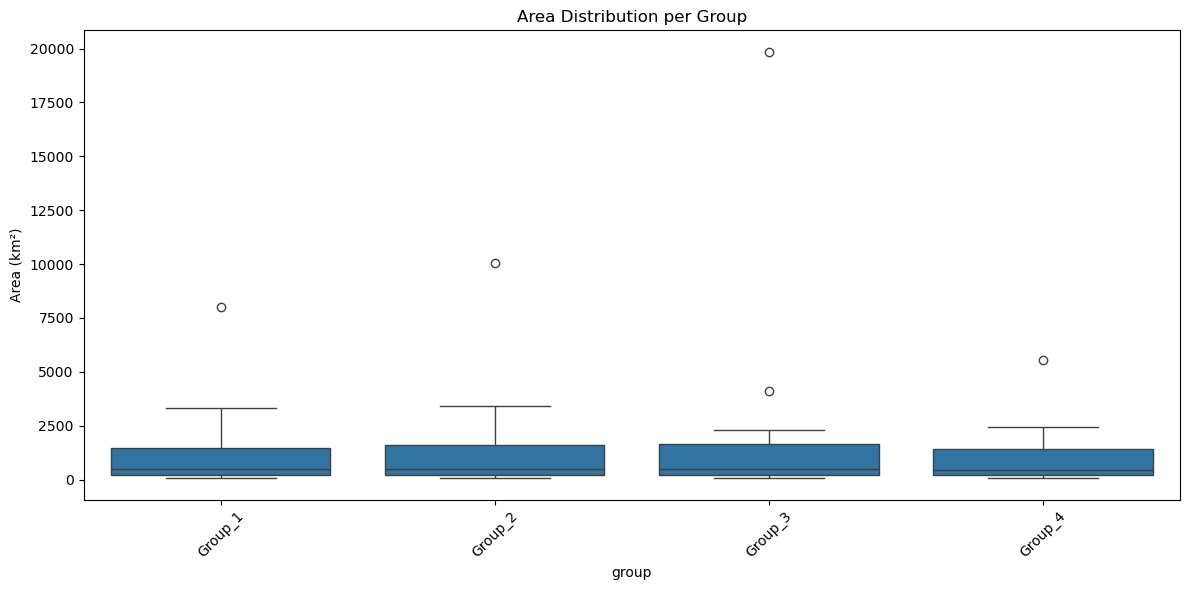

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_df = pd.concat([
    g.assign(group=group_name) for group_name, g in groups_df.items()
])

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='group', y='area_estreams')
plt.title("Area Distribution per Group")
plt.ylabel("Area (km²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [194]:
combined_df[combined_df.group == GROUP]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id,group
0,O149431003,Le Touyre Ã Lavelanet et Ã Saint-Quentin-la-...,FR,FR_EAUFRANCE,Le Touyre à Lavelanet et à Saint-Quentin-la-Tour,1.850824,42.940862,1.850824,42.940862,442,...,0.000,1.0,23.0,77.0,0.0,0.000,52.863,47.137,FR004136,Group_2
1,O023402001,Le Ger Ã Aspet [2],FR,FR_EAUFRANCE,Le Ger à Aspet [2],0.795350,43.021419,0.795350,43.021419,416,...,0.000,0.0,4.0,87.0,9.0,0.000,49.849,50.151,FR004091,Group_2
2,O182401001,La LÃ¨ze au Fossat,FR,FR_EAUFRANCE,La Lèze au Fossat,1.408875,43.174989,1.408875,43.174989,244,...,2.529,2.0,2.0,98.0,0.0,0.438,98.245,1.317,FR004148,Group_2
3,O144291002,Le Grand Hers Ã Laroque-d'Olmes et au Peyrat,FR,FR_EAUFRANCE,Le Grand Hers à Laroque-d'Olmes et au Peyrat,1.935437,42.954244,1.935437,42.954244,413,...,0.020,2.0,11.0,88.0,1.0,0.000,77.255,22.745,FR004132,Group_2
4,O095000101,Le Louge au Fousseret,FR,FR_EAUFRANCE,Le Louge au Fousseret,1.059950,43.267264,1.059950,43.267264,246,...,16.014,3.0,29.0,71.0,0.0,5.462,94.538,0.000,FR004119,Group_2
5,O187401001,La LÃ¨ze Ã Labarthe-sur-LÃ¨ze,FR,FR_EAUFRANCE,La Lèze à Labarthe-sur-Lèze,1.406594,43.451190,1.406594,43.451190,159,...,24.070,3.0,14.0,86.0,0.0,18.370,81.174,0.456,FR004152,Group_2
6,O198431001,O1984310,FR,FR_EAUFRANCE,Le Touch à Toulouse [Saint-Martin-du-Touch],1.376184,43.598683,1.376184,43.598683,143,...,87.251,3.0,71.0,29.0,0.0,42.497,57.503,0.000,FR001583,Group_2
7,O001004003,O0010040,FR,FR_EAUFRANCE,La Garonne à Arlos et à Saint-Béat,0.692109,42.915356,0.692109,42.915356,500,...,1.160,6.0,2.0,94.0,4.0,0.000,6.221,93.779,FR001499,Group_2
8,O050252002,O0502520,FR,FR_EAUFRANCE,Le Salat à Saint-Lizier [Saint Girons],1.140881,42.991501,1.140881,42.991501,382,...,0.000,2.0,18.0,69.0,13.0,0.000,22.730,77.271,FR001542,Group_2
9,O059251001,O0592510,FR,FR_EAUFRANCE,Le Salat à Roquefort-sur-Garonne,0.973925,43.154443,0.973925,43.154443,270,...,1.703,3.0,19.0,71.0,10.0,0.200,43.064,56.734,FR001545,Group_2


<Axes: >

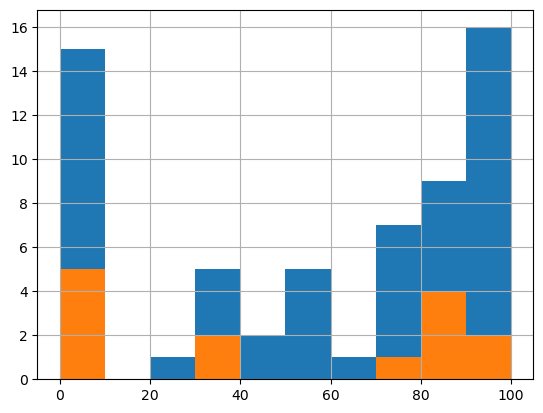

In [24]:
GROUP = "Group_2"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters.perm_low_cont2.hist()
estreams_attributes_clipped_filters.loc[list_cal].sort_values("area_estreams").perm_low_cont2.hist()

<Axes: >

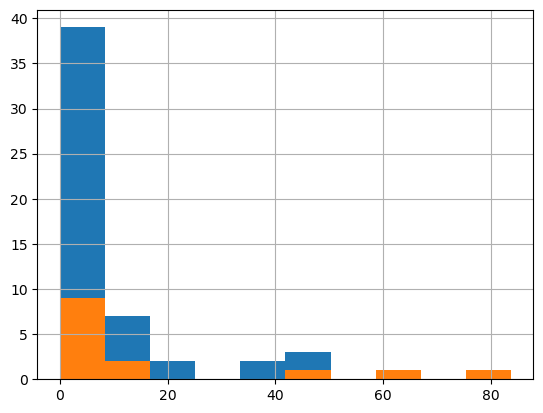

In [22]:
GROUP = "Group_2"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters2.perm_high_cont2.hist()
estreams_attributes_clipped_filters2.loc[list_cal].sort_values("area_estreams").perm_high_cont2.hist()

<Axes: >

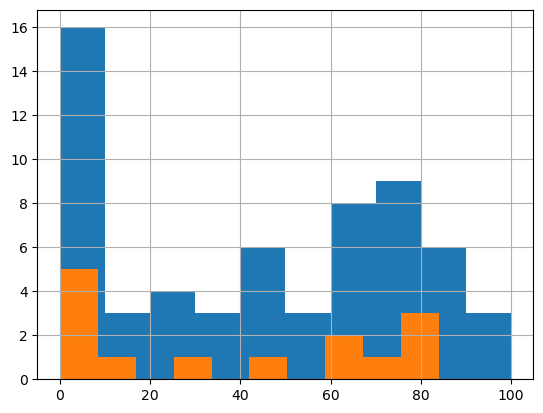

In [25]:
GROUP = "Group_2"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters.perm_low_glob2.hist()
estreams_attributes_clipped_filters.loc[list_cal].sort_values("area_estreams").perm_low_glob2.hist()

<Axes: >

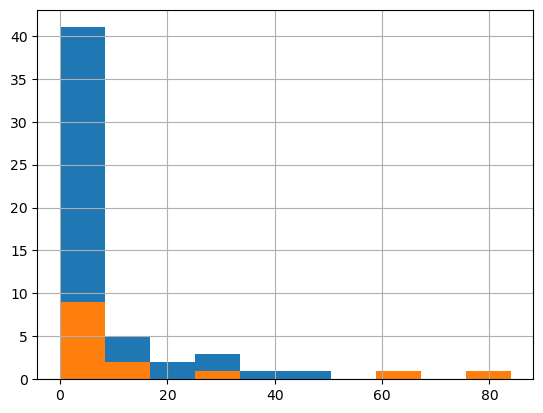

In [26]:
GROUP = "Group_2"
list_cal = combined_df[combined_df.group == GROUP].basin_id.tolist()
estreams_attributes_clipped_filters2.perm_high_glob2.hist()
estreams_attributes_clipped_filters2.loc[list_cal].sort_values("area_estreams").perm_high_glob2.hist()

In [45]:
df = combined_df[combined_df.group != GROUP]
df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_2005,stations_num_p_mean,perm_high_glob2,perm_medium_glob2,perm_low_glob2,perm_high_cont2,perm_medium_cont2,perm_low_cont2,basin_id,group
0,L001061001,L0010610,FR,FR_EAUFRANCE,La Vienne à Peyrelevade [Servières],2.007374,45.702142,2.007374,45.702142,618,...,0.068,1.0,0.0,19.0,81.0,0.000,0.000,100.000,FR001178,Group_1
1,L503401001,L'Ardour Ã Folles [Forgefer],FR,FR_EAUFRANCE,L'Ardour à Folles [Forgefer],1.495670,46.096669,1.495670,46.096669,318,...,0.000,2.0,0.0,16.0,84.0,0.000,22.953,77.047,FR003965,Group_1
2,L513401001,La Semme Ã Droux,FR,FR_EAUFRANCE,La Semme à Droux,1.142102,46.150780,1.142102,46.150780,186,...,0.000,2.0,0.0,25.0,75.0,0.000,4.988,95.012,FR003967,Group_1
3,L562301001,La Benaize Ã Jouac,FR,FR_EAUFRANCE,La Benaize à Jouac,1.258883,46.355026,1.258883,46.355026,181,...,0.284,3.0,0.0,13.0,87.0,0.000,8.927,91.073,FR003974,Group_1
4,L532301001,L5323010,FR,FR_EAUFRANCE,La Brame à Oradour-Saint-Genest,0.998967,46.251704,0.998967,46.251704,161,...,0.284,2.0,0.0,38.0,62.0,0.000,3.759,96.241,FR001245,Group_1
5,L081301001,L0813010,FR,FR_EAUFRANCE,La Glane à Saint-Junien [Le Dérot],0.915545,45.913135,0.915545,45.913135,208,...,1.299,4.0,0.0,23.0,77.0,0.000,0.000,100.000,FR001197,Group_1
6,L023151001,Le Taurion Ã Pontarion,FR,FR_EAUFRANCE,Le Taurion à Pontarion,1.846800,45.996519,1.846800,45.996519,440,...,0.000,6.0,0.0,9.0,91.0,0.000,0.000,100.000,FR003938,Group_1
7,L440000101,La Petite Creuse Ã Genouillac [EDF],FR,FR_EAUFRANCE,La Petite Creuse à Genouillac [EDF],1.993689,46.357709,1.993689,46.357709,272,...,0.445,6.0,0.0,46.0,54.0,0.548,23.194,76.259,FR003959,Group_1
8,L441171001,L4411710,FR,FR_EAUFRANCE,La Petite Creuse à Fresselines [Puy Rageaud],1.688999,46.385936,1.688999,46.385936,218,...,0.473,7.0,1.0,59.0,40.0,0.360,44.733,54.906,FR001231,Group_1
9,L032151001,L0321510,FR,FR_EAUFRANCE,Le Taurion à Saint-Priest-Taurion [Le Chauvan],1.409804,45.904600,1.409804,45.904600,237,...,0.079,8.0,1.0,33.0,66.0,0.000,11.962,88.039,FR001189,Group_1


In [61]:
five_cats

,basin_id,gauge_id,country,area_offic,area_estre,area_flag,area_rel,start_date,end_date,gauge_flag,upstream,group,layer,path,geometry
0,ES000331,9017,ES,9612.00,9567.466,0,0.463317,1929-01-01,2019-09-30,E,33,540,ES000331,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((0.10791 41.54541 0, 0.10624 41.545..."
1,DEBU1959,26900400,DE,27088.00,27100.000,0,-0.044300,1901-01-01,2021-07-31,B,210,1,five_catchments,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((7.14374 50.13125 0, 7.14374 50.131..."
2,FR003986,L720061001,FR,20821.55,20819.208,0,0.011248,2009-01-01,2023-09-30,C,127,732,five_catchments,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((0.24958 47.15625 0, 0.24791 47.156..."
3,FR001604,O262002002,FR,13730.00,13752.051,0,-0.160605,1972-08-01,2023-09-30,C,187,541,five_catchments,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((1.23791 43.84291 0, 1.23791 43.845..."
4,PL000936,152210060,PL,27802.88,28500.000,0,-2.507366,1964-11-01,2022-10-31,B,127,23,five_catchments,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((20.85041 53.72625 0, 20.85041 53.7..."


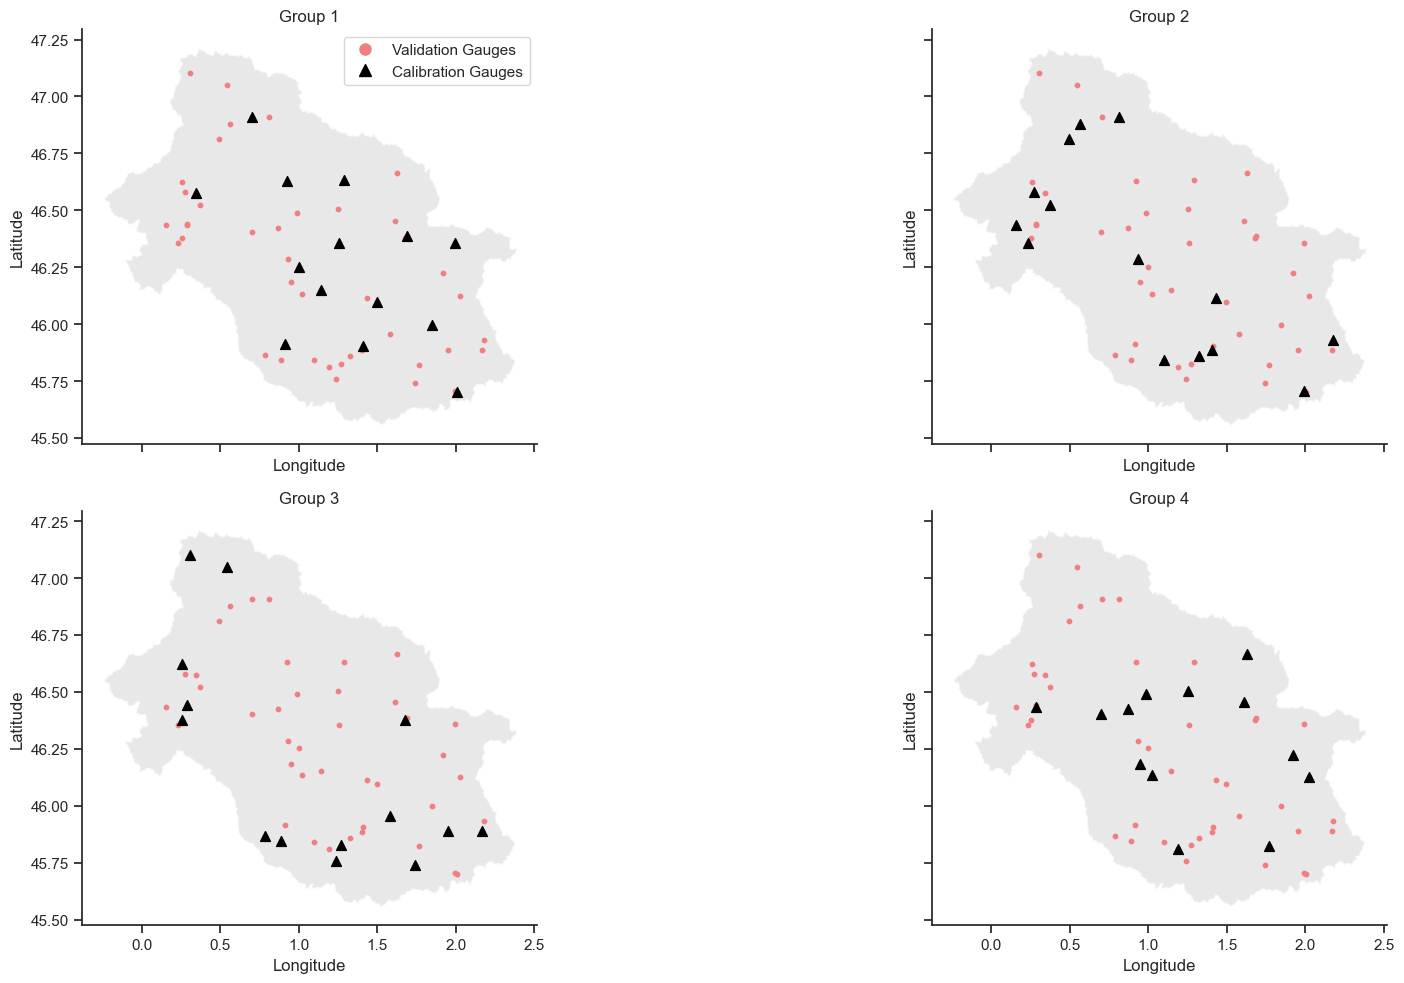

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

sns.set_theme(style="ticks")

# Prepare data
df = estreams_attributes_clipped_filters2.copy()
group_coords = [group[["basin_id"]] for group in groups_df.values()]
group_coords = [network_estreams.loc[g["basin_id"].tolist()] for g in group_coords]

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Base map
    five_cats[five_cats.basin_id == "FR003986"].plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    #rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # All gauges in red (background)
    ax.scatter(
        df["lon"], df["lat"],
        color='lightcoral', s=10, label='Validation Gauges', zorder=2
    )

    if i < len(group_coords):
        # Plot group gauges (triangle)
        ax.scatter(
            group_coords[i]["lon"],
            group_coords[i]["lat"],
            marker='^',
            color='black',
            s=50,
            zorder=3,
            label=f'Group {i+1}'
        )
        ax.set_title(f"Group {i+1}")
    else:
        ax.set_title("Empty")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(False)
    sns.despine(ax=ax)

# Legend (shared handles)
validation_handle = mlines.Line2D([], [], color='lightcoral', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')
axes[0].legend(handles=[validation_handle, calibration_handle], loc='upper right')

plt.tight_layout()
plt.show()


In [1]:
combined_df.columns


KeyboardInterrupt



In [ ]:
combined_df.to_csv("../data/network_estreams_vienne_55_gauges.csv")

# End